# Cargar el modelo

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

imagen_alto = 128
imagen_ancho = 128
canales_de_color = 3

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(imagen_alto, imagen_ancho, canales_de_color)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

input_shape = tf.keras.Input(shape=(imagen_alto, imagen_ancho, canales_de_color))

# Definir el modelo con la misma arquitectura
model = models.Sequential([
    (input_shape),  # Capa de entrada (128x128x1)
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax') # Capa de salida (2)
]) 

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Cargar los pesos en el modelo
model.load_weights('pesos_modelo_cnn.weights.h5')

In [3]:
loaded_model = tf.keras.models.load_model('modelo_cnn.keras')

loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,803,531 (37.40 MB)

 Trainable params: 3,267,843 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,535,688 (24.93 MB)

# Cargar la imagen

Using OpenSlide from c:\Users\achav\Documents\Osteoartritis\osteo\Lib\site-packages\openslide\__init__.py


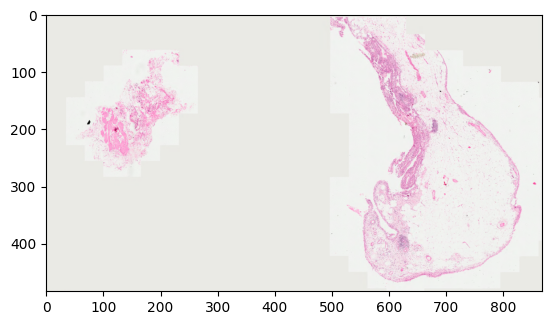

In [4]:
import os

OPENSLIDE_PATH = r'C:\Users\achav\Documents\Osteoartritis\openslide-win64\bin'

if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
        print('Using OpenSlide from', openslide.__file__)
else:
    import openslide

import numpy as np
import matplotlib.pyplot as plt

plate_name = "Ms-13-22-1_001"
plate_path = plate_name + ".svs"
path = f"assets/{plate_path}"

# Check if file exists
if not os.path.isfile(path):
    print(f"File {path} not found")

slide = openslide.OpenSlide(path)

# Get a thumbnail of the whole slide
thumbnail = slide.get_thumbnail((slide.dimensions[0] // 64, slide.dimensions[1] // 64))

# Convert the thumbnail to a numpy array
thumbnail = np.array(thumbnail)

# Display the thumbnail
plt.imshow(thumbnail)

# Predecir y crear una nueva imagen con las predicciones

In [7]:
import cv2
from collections import defaultdict

class_colors = {0: (0, 0, 255), 1: (255, 0, 0), 2: (0, 255, 0)}
level = 0

# Get the dimensions of the slide
width, height = slide.level_dimensions[level]

print(slide.level_dimensions)
print(slide.level_downsamples)
print(width, height)

# Create a count dict to store the number of tiles for each class
count = defaultdict(int)

# Convert the image to a numpy array
results = np.zeros((width, height, 3), dtype=np.uint8)

print(results.shape)
for i in range(0, width, 1024):
    # print(f"i: {i}")
    for j in range(0, height, 1024):
        try:
            
            image = slide.read_region((i, j), level, (1024, 1024)).convert("RGB")
            # Show thumbnail
            image = image.resize((128, 128))  # Ajustar al tamaño esperado por el modelo
            image = np.array(image)
            # plt.imshow(image)

            # Asegurarse de que la imagen tiene la forma correcta (128, 128, 3)
            image = np.expand_dims(image, axis=0)  # Añadir una dimensión para el batch
            # Hacer predicción con el modelo
            prediction = model.predict(image, verbose=0)

            print(prediction)

            print(sum(prediction[0]))

            # Obtener la clase con la mayor probabilidad
            prediction = np.argmax(prediction)
            # print(f"Prediction: {prediction}")
            
            # Pintar la región de la imagen original con el color de la clase predicha
            cv2.rectangle(results, (i, j), (i + 1024, j + 1024), class_colors[prediction], -1)
            
            # Ajustar el tamaño del bloque a 4x4 en la matriz de resultados
            count[prediction] += 1

        except Exception as e:
            import winsound
            winsound.PlaySound("SystemExclamation", winsound.SND_ALIAS)
            print(f"Error: {e}")

# Reduce in a factor of 4
# cv2.imwrite("original.png", cv2.resize(thumbnail, (width, height), interpolation=cv2.INTER_NEAREST))
# cv2.imwrite("results.png", cv2.resize(results, (width, height), interpolation=cv2.INTER_NEAREST))

print(count)

((55635, 30978), (13908, 7744), (3477, 1936))
(1.0, 4.000236983827609, 16.000947935310435)
55635 30978
(55635, 30978, 3)
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[2.0712273e-16 1.0000000e+00 0.0000000e+00]]
1.0000000000000002
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.0
[[0. 1. 0.]]
1.

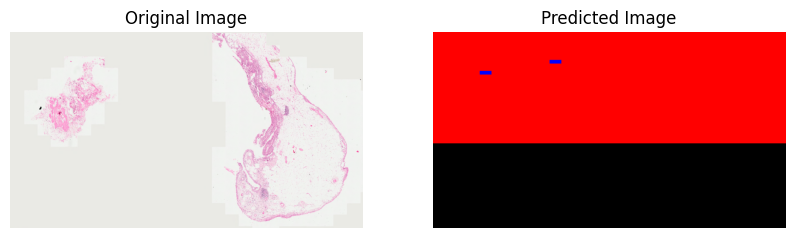

In [8]:
# Compare original image with the predicted image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)

# Resize the results to the same size as the original image
results = cv2.resize(results, (thumbnail.shape[1], thumbnail.shape[0]))

plt.imshow(results)
plt.title("Predicted Image")
plt.axis("off")

plt.show()


In [ ]:
print(results.shape, thumbnail.shape)

In [ ]:
image = slide.read_region((0, 0), 2, (slide.level_dimensions[2][1], slide.level_dimensions[2][0] //2)).convert("RGB")

image = np.array(image)
plt.imshow(image)




In [ ]:
values = [0.024, 0.064, 0.175, 0.475, 0.024, 0.064, 0.175]

print(values)

print(sum(values))